# EXPONENTIAL SMOOTHING HYPERPARAMETER TUNING WITH GENETIC ALGORITHM

### Import libraries

In [504]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [505]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.utils.plotting import plot_series

### Data: Margherita pizzas sold per day

In [506]:
y = pd.read_csv("margherita_daily.csv")
y.Data = y.Data.apply(lambda x : pd.to_datetime(x))
y.rename(columns={"Quantity":"Margherita"},inplace=True)
y

,Data,Margherita
0,2021-06-01,21.00
1,2021-06-02,37.00
2,2021-06-03,19.00
3,2021-06-04,22.00
4,2021-06-05,61.00
...,...,...
521,2022-11-05,61.33
522,2022-11-06,42.00
523,2022-11-07,7.00
524,2022-11-08,18.00


### Graph the time series

Text(0.5, 1.0, 'Last 180 days')

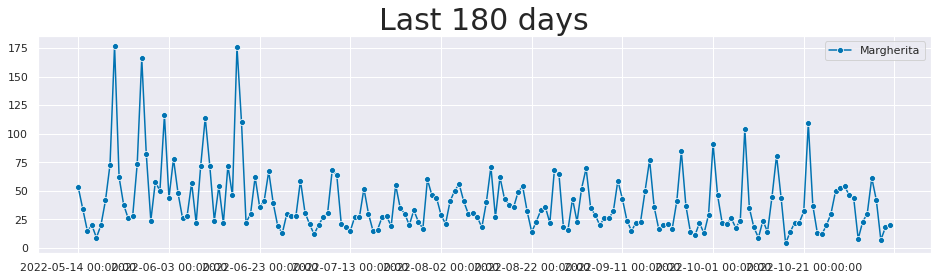

In [507]:
plot_series(y.iloc[-180:].set_index("Data"), labels=["Margherita"])
plt.title("Last 180 days",fontsize = 30)

Text(0.5, 1.0, 'Last 90 days')

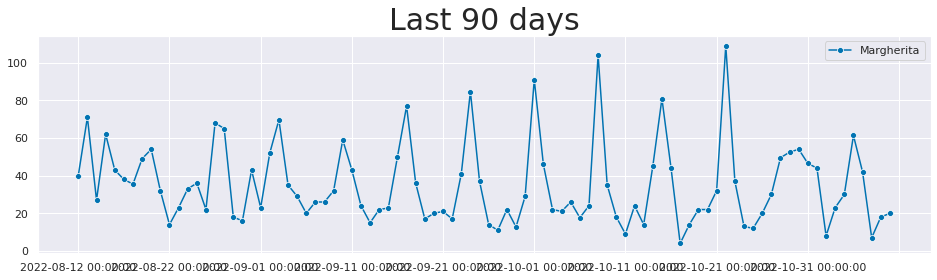

In [508]:
plot_series(y.iloc[-90:].set_index("Data"), labels=["Margherita"])
plt.title("Last 90 days",fontsize = 30)

Text(0.5, 1.0, 'Last 30 days')

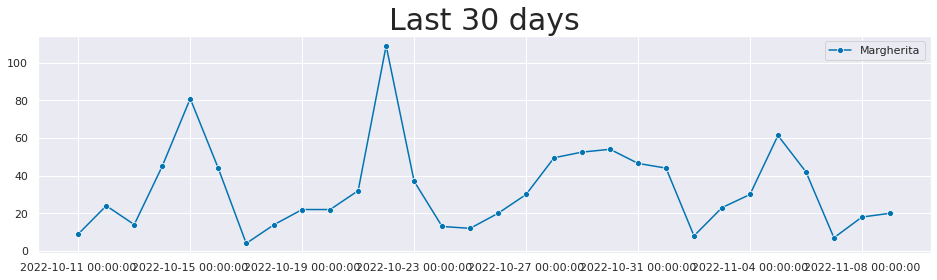

In [509]:
plot_series(y.iloc[-30:].set_index("Data"), labels=["Margherita"])
plt.title("Last 30 days",fontsize = 30)

### Time serie split and forecasting horizon generation (7 days: 1 week)
#### One split for the test and one for the validation

In [510]:
y_train_val, y_val = temporal_train_test_split(y[["Margherita"]], test_size=7)
fh_val = ForecastingHorizon(y_val.index,is_relative=False) #
fh_val

ForecastingHorizon([519, 520, 521, 522, 523, 524, 525], dtype='int64', is_relative=False)

In [511]:
y_train_val

,Margherita
0,21.0
1,37.0
2,19.0
3,22.0
4,61.0
...,...
514,52.5
515,54.0
516,46.5
517,44.0


In [512]:
y_val

,Margherita
519,23.00
520,30.00
521,61.33
522,42.00
523,7.00
524,18.00
525,20.00


In [513]:
y_train, y_test = temporal_train_test_split(y_train_val, test_size=7)
fh = ForecastingHorizon(y_test.index,is_relative=False) #
fh

ForecastingHorizon([512, 513, 514, 515, 516, 517, 518], dtype='int64', is_relative=False)

In [514]:
y_train

,Margherita
0,21.0
1,37.0
2,19.0
3,22.0
4,61.0
...,...
507,109.0
508,37.0
509,13.0
510,12.0


In [515]:
y_test

,Margherita
512,30.0
513,49.5
514,52.5
515,54.0
516,46.5
517,44.0
518,8.0


In [516]:
#for storing the results
results = []

### Exoponetial smoothing

In [517]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

{'Model name': 'ExponentialSmoothing_default', 'MAPE': 0.7101162865775036}


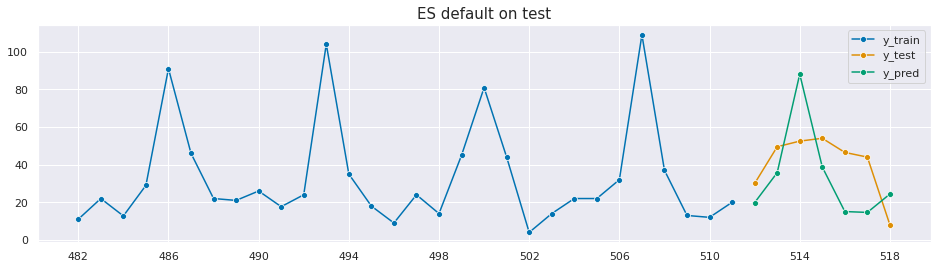

In [518]:
forecaster = ExponentialSmoothing(
        trend= "add",
        seasonal="additive", 
        sp = 7,
        )

forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict(fh)
plot_series(y_train.iloc[-30:], y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
plt.title("ES default on test",fontsize = 15)

# MAPE
mape = mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

data = {"Model name": "ExponentialSmoothing_default", "MAPE": mape}
print(data)

{'Model name': 'ExponentialSmoothing_default', 'MAPE': 0.7101162865775036, 'MAPE_val': 0.344315005871173}


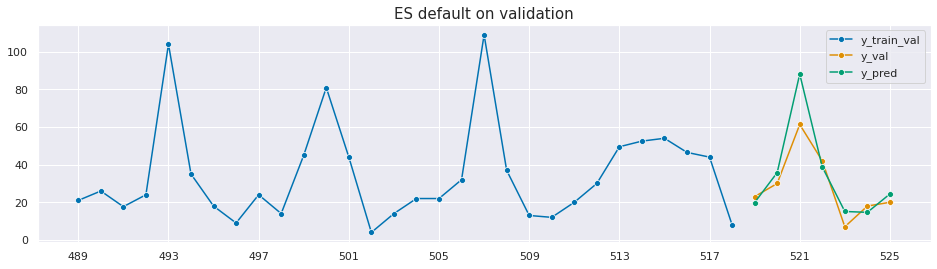

In [519]:
forecaster = ExponentialSmoothing(
        trend= "add",
        seasonal="additive", 
        sp = 7,
        )

forecaster.fit(y_train, fh=fh_val)
y_pred = forecaster.predict(fh_val)
plot_series(y_train_val.iloc[-30:], y_val, y_pred, labels=["y_train_val", "y_val", "y_pred"])
plt.title("ES default on validation",fontsize = 15)

# MAPE
mape = mean_absolute_percentage_error(y_val, y_pred, symmetric=False)

data["MAPE_val"] = mape
results.append(data)
print(data)

### AUTO ETS

{'Model name': 'AutoETS', 'MAPE': 0.6104325249635324}


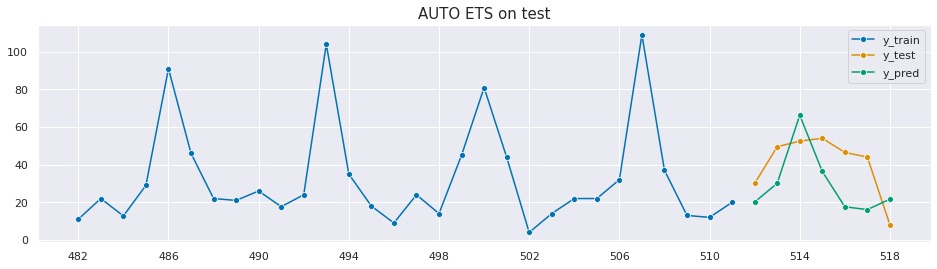

In [520]:
from sktime.forecasting.ets import AutoETS
forecaster = AutoETS(auto=True, sp=7, n_jobs=-1, trend="add")

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train.iloc[-30:], y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
plt.title("AUTO ETS on test",fontsize = 15)

# MAPE
mape = mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

data = {"Model name": "AutoETS", "MAPE": mape}
print(data)

{'Model name': 'AutoETS', 'MAPE': 0.6104325249635324, 'MAPE_val': 0.2925263064631927}


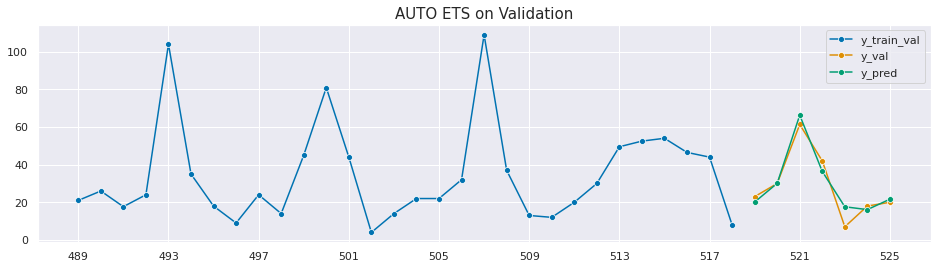

In [521]:
forecaster = AutoETS(auto=True, sp=7, n_jobs=-1, trend="add")

forecaster.fit(y_train, fh=fh_val)
y_pred = forecaster.predict(fh_val)
plot_series(y_train_val.iloc[-30:], y_val, y_pred, labels=["y_train_val", "y_val", "y_pred"])
plt.title("AUTO ETS on Validation",fontsize = 15)

# MAPE
mape = mean_absolute_percentage_error(y_val, y_pred, symmetric=False)

data["MAPE_val"] = mape
results.append(data)
print(data)

### Genetic algo for hyperparameter tuning of Exponetial smoothing
#### Let's use a genetic algo for "fitting" (find the best hyperparametrization) the exponential smoothing to the last 180 days
##### Package used for GA: pygad

In [522]:
y_train_genetic, y_test_genetic = temporal_train_test_split(y_train_val, test_size=180)
fh_genetic = ForecastingHorizon(y_test_genetic.index,is_relative=False)
fh_genetic

ForecastingHorizon([339, 340, 341, 342, 343, 344, 345, 346, 347, 348,
            ...
            509, 510, 511, 512, 513, 514, 515, 516, 517, 518],
           dtype='int64', length=180, is_relative=False)

In [523]:
import pygad

In [524]:
last_fitness = 0

In [525]:
def on_generation(ga_instance):
    print("on_generation()")
    global last_fitness
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]))
    print("Change     = {change}".format(change=ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1] - last_fitness))
    last_fitness = ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]

def on_stop(ga_instance, last_population_fitness):
    print("on_stop()")

In [526]:
def fitness_func(solution, solution_idx):

    try:
        forecaster = ExponentialSmoothing(
            trend= "add",
            damped_trend=True,
            seasonal="add",
            remove_bias=True, 
            sp = 7,
            smoothing_level= solution[0],
            smoothing_trend=solution[1],
            smoothing_seasonal=solution[2],
            damping_trend=solution[3]
            )
    except:
        return -9999
        

    forecaster.fit(y_train_genetic, fh=fh_genetic)
    y_pred = forecaster.predict(fh_genetic)

    # MAPE
    try:
        mape = mean_absolute_percentage_error(y_test_genetic, y_pred, symmetric=False)
    except:
        return -9999

    fitness = 1/(mape)
    
    return fitness

In [527]:
num_generations = 50
num_parents_mating = 100

fitness_function = fitness_func

sol_per_pop = 200
num_genes = 4

init_range_low = 0
init_range_high = 0.3

parent_selection_type = "sss"
keep_parents = -1 

crossover_type = "single_point"
crossover_probability=0.5

mutation_type = "random"
mutation_probability = 0.25

random_mutation_min_val=-0.01
random_mutation_max_val=0.01

In [528]:
gene_space = []

# continuous parameters (alpha, beta, gamma, phi)
for i in range(0,4):
    gene_space.append({"low":-1, "high":1,"step": 0.01})

gene_space

[{'low': -1, 'high': 1, 'step': 0.01},
 {'low': -1, 'high': 1, 'step': 0.01},
 {'low': -1, 'high': 1, 'step': 0.01},
 {'low': -1, 'high': 1, 'step': 0.01}]

In [529]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       on_generation=on_generation,
                       on_stop=on_stop,
                       #stop_criteria=["saturate_15"],
                       allow_duplicate_genes=True,
                       gene_type=float,
                       gene_space = gene_space,
                       save_solutions=True,
                       random_mutation_min_val= random_mutation_min_val,
                       random_mutation_max_val= random_mutation_max_val)

/home/davide/.local/lib/python3.8/site-packages/pygad/pygad.py:469: UserWarning:

The percentage of genes to mutate (mutation_percent_genes=10) resutled in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.

/home/davide/.local/lib/python3.8/site-packages/pygad/pygad.py:795: UserWarning:

Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.



In [ ]:
ga_instance.run();

In [531]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))
if ga_instance.best_solution_generation != -1:
    print("Best fitness value reached after {best_solution_generation} generations.".format(best_solution_generation=ga_instance.best_solution_generation))

/home/davide/.local/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning:

overflow encountered in matmul

/home/davide/.local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning:

invalid value encountered in subtract

/home/davide/.local/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/davide/.local/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/davide/.local/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/davide/.local/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning:

overflow encountered in matmul

/home/davide/.local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning:


Parameters of the best solution : [ 0.69  0.58  0.13 -0.51]
Fitness value of the best solution = 3.1500911840058348
Index of the best solution : 0
Best fitness value reached after 46 generations.


/home/davide/.local/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning:

overflow encountered in matmul

/home/davide/.local/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning:

invalid value encountered in subtract

/home/davide/.local/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



### Parameters of the best solution : [ 0.69  0.58  0.13 -0.51]
### Fitness value of the best solution = 3.1500911840058348
### Best fitness value reached after 46 generations.

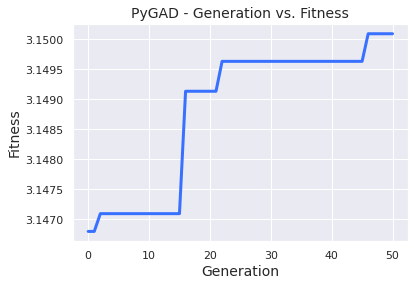

In [532]:
ga_instance.plot_fitness(plot_type="plot");

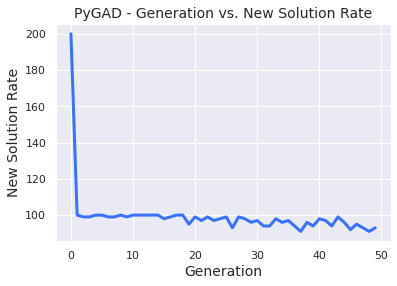

In [533]:
ga_instance.plot_new_solution_rate(plot_type="plot");

### Exoponetial smoothing with best parameters found

{'Model name': 'ExponentialSmoothing_genetic', 'MAPE': 0.694593570799978}


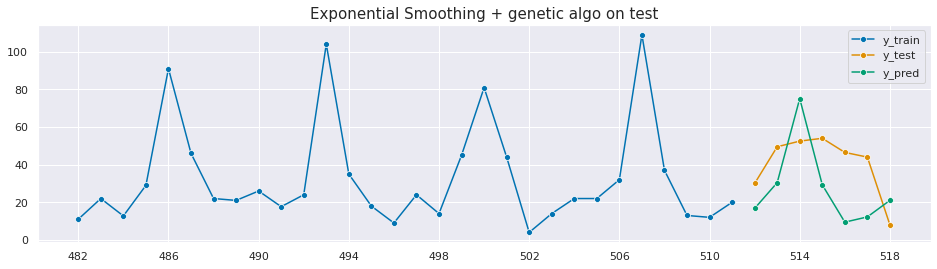

In [534]:
forecaster = ExponentialSmoothing(
            trend= "add",
            damped_trend=True,
            seasonal="add",
            remove_bias=True, 
            sp = 7,
            smoothing_level= solution[0],
            smoothing_trend=solution[1],
            smoothing_seasonal=solution[2],
            damping_trend=solution[3]
            )

forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict(fh)
plot_series(y_train.iloc[-30:], y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
plt.title("Exponential Smoothing + genetic algo on test",fontsize = 15)

# MAPE
mape = mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

data = {"Model name": "ExponentialSmoothing_genetic", "MAPE": mape}
print(data)

{'Model name': 'ExponentialSmoothing_genetic', 'MAPE': 0.3174511281061849}


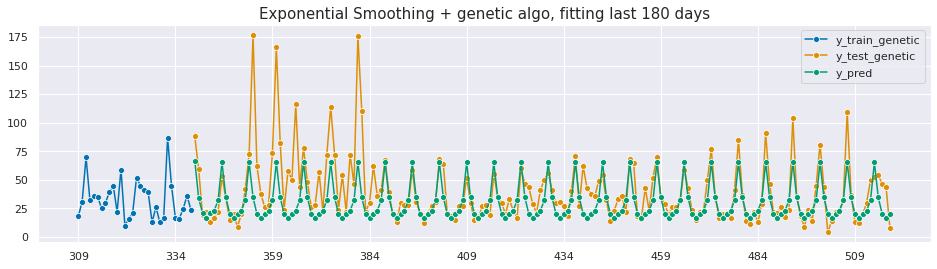

In [535]:
forecaster.fit(y_train_genetic, fh=fh_genetic)
y_pred = forecaster.predict(fh_genetic)
plot_series(y_train_genetic.iloc[-30:], y_test_genetic, y_pred, labels=["y_train_genetic", "y_test_genetic", "y_pred"])
plt.title("Exponential Smoothing + genetic algo, fitting last 180 days",fontsize = 15)

# MAPE
mape = mean_absolute_percentage_error(y_test_genetic, y_pred, symmetric=False)

print({"Model name": "ExponentialSmoothing_genetic", "MAPE": mape})

{'Model name': 'ExponentialSmoothing_genetic', 'MAPE': 0.694593570799978, 'MAPE_val': 0.21919610796778422}


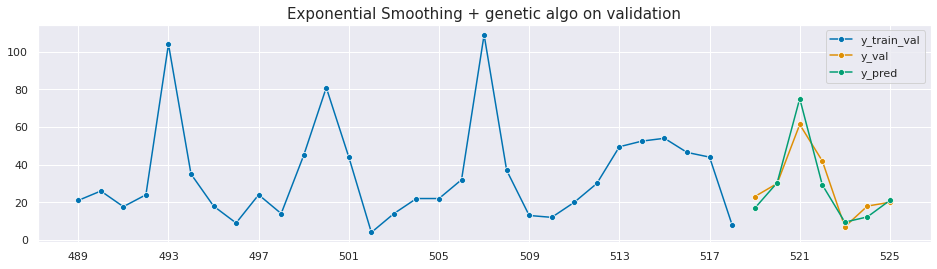

In [536]:
forecaster = ExponentialSmoothing(
            trend= "add",
            damped_trend=True,
            seasonal="add",
            remove_bias=True, 
            sp = 7,
            smoothing_level= solution[0],
            smoothing_trend=solution[1],
            smoothing_seasonal=solution[2],
            damping_trend=solution[3]
            )

forecaster.fit(y_train, fh=fh_val)
y_pred = forecaster.predict(fh_val)
plot_series(y_train_val.iloc[-30:], y_val, y_pred, labels=["y_train_val", "y_val", "y_pred"])
plt.title("Exponential Smoothing + genetic algo on validation",fontsize = 15)

# MAPE
mape = mean_absolute_percentage_error(y_val, y_pred, symmetric=False)

data["MAPE_val"] = mape
results.append(data)
print(data)

## Results

In [543]:
df_results = pd.DataFrame.from_dict(results)
df_results.set_index("Model name",inplace=True)
df_results.rename(columns={"MAPE":"MAPE test","MAPE_val":"MAPE validation"},inplace=True)
df_results

,MAPE test,MAPE validation
Model name,,
ExponentialSmoothing_default,0.710116,0.344315
AutoETS,0.610433,0.292526
ExponentialSmoothing_genetic,0.694594,0.219196


In [544]:
df_results.to_csv("final_results.csv")

In [545]:
import plotly.express as px

In [546]:
fig = px.bar(df_results,barmode="group",text_auto=".2%", title="Final results")
fig.show()